# Import

In [1]:
import glob as g

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

In [2]:
def importer(dossier, **kwargs):
        
    separateur = kwargs['sep']
    liste_ext = {'xlsx':'excel','csv':'csv'}
    
    globals()['list_df'] = []        
    fichiers = [file for file in g.glob(dossier+'/*')]
    
    if fichiers == []:
        dossier = dossier.split('/')
        dossier = "./"+dossier[1]+"\\"+dossier[2]
        fichiers.append(dossier)
        dossier = dossier.split('\\')[0]
        
    for fichier in fichiers:
        fichier = fichier.split('\\')
        (fnom,fext) = fichier[len(fichier)-1].split('.')
        fichier = str(dossier)+'/'+str(fichier[1])

        if fext in liste_ext.keys():
            exec("globals()[fnom] = pd.read_"+liste_ext[fext]+"(fichier, sep=separateur)")
            print(fichier + ": Importé dans '"+fnom+"'")
            list_df.append(fnom)

        else:
            print('extension non reconnu, liste compatible: ')
            print(liste_ext)
#findef

importer("./data_p10/billets.csv", sep=";")

./data_p10/billets.csv: Importé dans 'billets'


# Remplissage des valeurs null avec la régression linéaire.

<p>J'avais d'abord prévu de supprimer les cases concerné car utiliser la moyenne ou la médiane ou 0 ne sera pas pertinant dans la détection des faux billets</p>

```python
billets = billets.dropna()
```
<p>à la place on va effectuer une régression linéaire pour prédire la valeur qu'aurait du avoir les billets en question</p>

In [3]:
def homoscedasticite(X, residuals):
    p_value = het_white(residuals, sm.add_constant(X))[1]
    if p_value > 0.05:
        print("Les résidus suivent une homoscédasticité (p-value = {:.4f})".format(p_value))
    else:
        print("Les résidus ne suivent pas une homoscédasticité (p-value = {:.4f})".format(p_value))
    print("-----------------------------------------------------------------------------------")

def normalite(X, residuals):
    p_value = stats.shapiro(residuals).pvalue
    if p_value > 0.05:
        print("Les résidus suivent une distribution normale (p-value = {:.4f})".format(p_value))
    else:
        print("Les résidus ne suivent pas une distribution normale (p-value = {:.4f})".format(p_value))
    print("-----------------------------------------------------------------------------------")
        
def colinearite(df):
    X = df.drop(['is_genuine'], axis=1)

    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Afficher les résultats du test de colinéarité
    print("Résultats du test de colinéarité (VIF):")
    print(vif)

    # Afficher les variables présentant une colinéarité élevée (VIF > 5)
    high_vif_vars = vif[vif['VIF'] > 5]['Variable']
    if len(high_vif_vars) > 0:
        print("Variables avec une colinéarité élevée (VIF > 5):")
        print(high_vif_vars)
    print("-----------------------------------------------------------------------------------")
        
def remplace_null(df, **kwargs):
    
    # Séparer les données en deux ensembles
    train_data = df[df['margin_low'].notnull()]
    test_data = df[df['margin_low'].isnull()]

    # Diviser les données d'entraînement en X et y
    X_train = train_data.drop(['margin_low'], axis=1)
    y_train = train_data['margin_low']
    
    # Créer et entraîner le modèle de régression linéaire
    if kwargs.get('model', None) == None:
        model_lin = LinearRegression()
        model_lin.fit(X_train, y_train)
    else:
        model_lin = kwargs.get('model', None)

    # Prédire les valeurs manquantes dans l'ensemble de données vide
    X_test = test_data.drop(['margin_low'], axis=1)
    y_pred = model_lin.predict(X_test)
    
    # Remplacer les valeurs manquantes dans le DataFrame avec les valeurs prédites
    df.loc[df['margin_low'].isnull(), 'margin_low'] = y_pred
    
    # Calcul des résidus
    residuals = y_train - model_lin.predict(X_train)
    
    # Test de Colinearité
    colinearite(df)  
    
    # Test de normalité des résidus
    normalite(X_train, residuals)
        
    # Test d'homoscédasticité
    homoscedasticite(X_train, residuals)
    
    # Détermine les variables de corrélation pour l'affichage de la courbe
    print("Coefficient de corrélation de Spearman:")
    corr_matrix = billets.corr(method='spearman').abs()
    first_row = corr_matrix.iloc[0]
    first_row_df = pd.DataFrame(first_row).T
    sns.heatmap(corr_matrix, annot=True, cmap='autumn_r', square=True, cbar=False)
    plt.show()
    plt.close()

    # Définir les arguments pour le scatterplot et la ligne de régression
    print("Affichage de la régression linéaire:")
    scatter_kws = {'color': 'blue'}
    line_kws = {'color': 'red'}
    sns.regplot(x=df['length'], y=df['margin_low'], scatter_kws=scatter_kws, line_kws=line_kws)
    plt.show()
    plt.close()
    
    # Affiche les lignes qui ont subis des modifications
    print("Liste des lignes qui ont subis des modifications:")
    index_null = np.array(list(set(test_data.index.values)))
    display(billets.iloc[index_null].sort_index())
    
    return model_lin

Résultats du test de colinéarité (VIF):
       Variable            VIF
0      diagonal  169582.841274
1   height_left  115454.025762
2  height_right  104339.124559
3    margin_low      90.272310
4     margin_up     263.480696
5        length   31310.189212
Variables avec une colinéarité élevée (VIF > 5):
0        diagonal
1     height_left
2    height_right
3      margin_low
4       margin_up
5          length
Name: Variable, dtype: object
-----------------------------------------------------------------------------------
Les résidus ne suivent pas une distribution normale (p-value = 0.0000)
-----------------------------------------------------------------------------------
Les résidus ne suivent pas une homoscédasticité (p-value = 0.0000)
-----------------------------------------------------------------------------------
Coefficient de corrélation de Spearman:


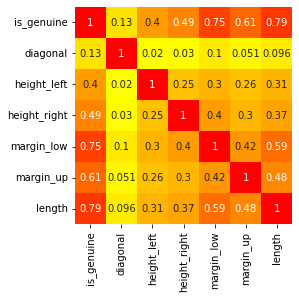

Affichage de la régression linéaire:


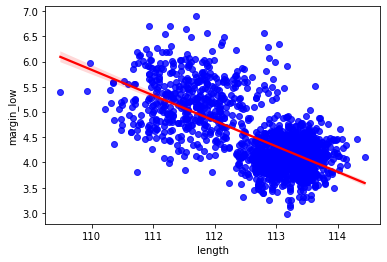

Liste des lignes qui ont subis des modifications:


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.064954,3.25,112.79
99,True,171.93,104.07,104.18,4.111990,3.14,113.08
151,True,172.07,103.80,104.38,4.134003,3.02,112.93
197,True,171.45,103.66,103.80,3.993571,3.62,113.27
241,True,171.83,104.14,104.06,4.140399,3.02,112.36
251,True,171.80,103.26,102.82,4.094284,2.95,113.22
284,True,171.92,103.83,103.76,4.074124,3.23,113.29
334,True,171.85,103.70,103.96,4.125390,3.00,113.36
410,True,172.56,103.72,103.51,4.080728,3.12,112.95
413,True,172.30,103.66,103.50,4.073633,3.16,112.95


In [4]:
model_lin = remplace_null(billets)

##### Même si les différents tests nous indiques que les conditions ne sont pas remplies pour effectuer une régression linéaire. Les données qui en sortent sont cependant cohérentes avec les chiffres observés; de plus le nombre de ligne concernées sont négligeables par rapport à l'ensemble du jeu de données, ce qui nous permet de garder les lignes dont les valeurs ont été comblées, sans que cela perturbe le modèle de prédiction qui va suivre.

# Classification non supervisé (kmeans)

In [5]:
def cercle_correlation(pca, x_y, colonnes, num_pdv):

    """
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : liste des colonnes que l'on souhaite utiliser pour l'ACP
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en pouce)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02)

        # Les étiquettes
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                colonnes[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))

    # Axes et display
    plt.axis('equal')
    plt.savefig("./images/cercle_correlation"+str(num_pdv)+".svg", format="svg")
    plt.close()

In [6]:
def Coude(data, k_range=(1, 10)):
    liste_inertielle = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        liste_inertielle.append(kmeans.inertia_)
    
    plt.figure(figsize=(10, 9))        
    plt.plot(range(0, 10), liste_inertielle)
    plt.title('Méthode du coude')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('inertia')
    plt.xticks(range(len(liste_inertielle)), range(k_range[0], k_range[1]+1))
    plt.savefig("./images/Coude.svg", format="svg")
    
    
    temp = []
    j=0
    for i in liste_inertielle:
        plt.axhline(y=i, color='k', linestyle='--', linewidth=0.5)
        if len(temp) >=2:
            res = (temp[j-2]/temp[j-1])*100-100
            if res <= 7.5:
                plt.close()
                return j-2
        temp.append(i)
        j=j+1

In [7]:
def Cluster_km(df_std, df_CP, CP, nb_cluster):
    kmeans = KMeans(n_clusters=nb_cluster, init='k-means++', max_iter=300, n_init=10, random_state=0)

    # On utilise la version simplifié par l'acp afin d'y voir plus claire sur le graphique
    acp_cluster = kmeans.fit_predict(df_CP)
    acp_cntr = kmeans.cluster_centers_
    
    # Créer le graphique
    plt.figure(figsize=(8, 6))
    plt.scatter(CP[:, 0], CP[:, 1], c=acp_cluster, cmap='tab10')
    plt.scatter(acp_cntr[:, 0], acp_cntr[:, 1], c='red', marker='x', s=50)  # Ajouter les centres de clusters en rouge avec un marqueur 'x'

    # Tracer les lignes entre les points de données et les centres de clusters
    for i in range(len(CP)):
        plt.plot([CP[i, 0], acp_cntr[acp_cluster[i], 0]], [CP[i, 1], acp_cntr[acp_cluster[i], 1]], c=plt.cm.tab10(acp_cluster[i]), linewidth=0.5)

    plt.title('Clustered Data')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
    plt.savefig("./images/clusters.svg", format="svg")
    plt.show()
    plt.close()
    
    # Cependant on conserve la version complète afin de pouvoir conserver des chiffres cohérants pour plus tard
    cluster = kmeans.fit_predict(df_std)
    cntr = kmeans.cluster_centers_
    
    return cluster, cntr

In [8]:
def Cluster_this(df, colonnes, **kwargs):
    #######################################
    # Paramètres disponibles
    # - nb_CP       | Nombre de Composant principaux dans l'ACP: (par défaut: auto déterminé par l'éboulie des valeurs propres)
    # - t_var       | Taux de variance minimum conservé après l'ACP: (par défaut: 80%)
    # - nb_clusters | Nombre de cluster souhaité (par défaut: auto déterminé par la technique du coude)
    
    df_originale = df
    df = df[colonnes]
    
    # STANDARDISATION
    scaler = RobustScaler()
    df_std = scaler.fit_transform(df)
        
    # Détermination automatique du nombre de composantes principaux optimale
    if kwargs.get('nb_CP', None) == None:
        nb_CP = len(colonnes)
        # ACP
        ACP = PCA(n_components=nb_CP)
        CP = ACP.fit_transform(df_std)

        # Eboulie des valeurs propres
        scree = (ACP.explained_variance_ratio_*100).round(2)
        scree_cum = scree.cumsum().round()
        x_list = range(1, nb_CP+1)

        # Détermine le nombre de Composant Principal (CP)
        # Taux de variance conservé de 80% minimum
        j=0
        for i in scree_cum:
            j=j+1
            if i >=kwargs.get('t_var', .80):
                nb_CP_opti = j
                break

        display("nb_CP_auto: "+str(nb_CP_opti)) 
    else:
        nb_CP_opti = kwargs.get('nb_CP', None)
        
    ACP = PCA(n_components=nb_CP_opti)
    CP = ACP.fit_transform(df_std)
    
    # Affiche les différents cercle de corrélation
    k=0
    for i in range(0, nb_CP_opti):
            for j in range(1,nb_CP_opti):
                if (i < j):
                    cercle_correlation(ACP, (i,j), colonnes, k)
                    k=k+1
    
    # Transforme CP en dataframe utilisable
    temp = []
    for i in range(1, nb_CP_opti+1):
        temp.append('CP'+str(i))
    df_CP = pd.DataFrame(data=CP, columns=temp)
    
    # Détermination automatique du nombre de cluster
    if kwargs.get('nb_clusters', None) == None:
        nb_clusters = Coude(df_CP)
        display("nb_clusters_auto: "+str(nb_clusters))
    else:
        nb_clusters = kwargs.get('nb_clusters', None)

    (clusters, cntr) = Cluster_km(df_std, df_CP, CP, 2)
    
    profil_cluster = pd.DataFrame(scaler.inverse_transform(cntr), columns=colonnes)
    display(profil_cluster)
    
    df_originale['cluster'] = clusters
    for i in df_originale['cluster'].unique():
        df_originale[df_originale['cluster']==i].to_csv('data_p10/cluster'+str(i)+'.csv', index=False)
    
    for i in colonnes:
        sns.catplot(data=df_originale, x="cluster", y=i, s=8)
        plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
        plt.savefig("./images/"+i+".svg", format="svg")
        plt.close()
    
    j = 0
    temp={}
    for i in colonnes:
        temp.update({j:colonnes[j]})
        j=j+1
        
    profil_cluster_std = pd.DataFrame(data=cntr)
    profil_cluster_std = profil_cluster_std.rename(columns=temp)
    profil_cluster_std = profil_cluster_std.T

    sns.heatmap(data=profil_cluster_std, annot=True, cmap='coolwarm')
    plt.savefig("./images/heatmap.svg", format="svg")
    plt.show()
    
    df_final = []    
    for i in range(0,nb_clusters):
        df_final.append(df_originale[df_originale['cluster']==i])
        
    return df_final

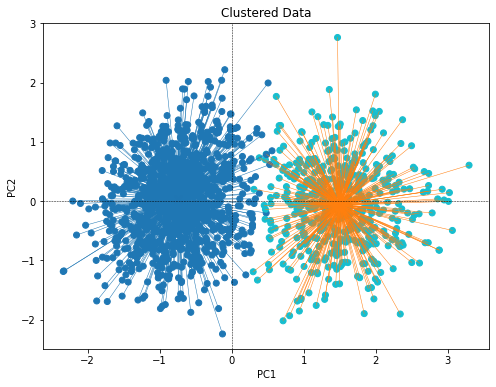

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.988446,103.945767,103.805727,4.115084,3.053078,113.194203
1,171.897702,104.199093,104.152238,5.227262,3.350645,111.634617


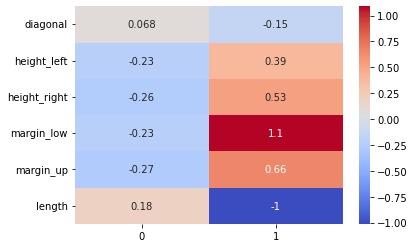

In [9]:
res = Cluster_this(billets, ['diagonal','height_left','height_right','margin_low','margin_up','length'], nb_clusters=2, nb_CP=6)

vrai_billet = res[0]
faux_billet = res[1]

In [10]:
def taux(df):
    total = len(df['is_genuine'])
    nb_vrai = len(df[df['is_genuine']==True])
    nb_faux = len(df[df['is_genuine']==False])
    
    return "taux de vrai = "+str((nb_vrai/total)*100), "taux de faux = "+str((nb_faux/total)*100)
#fin def    

print("cluster Vrai billets: ")
for i in taux(vrai_billet):
    print(i)
print("------------------------------------------")

print("cluster Faux billets: ")
for i in taux(faux_billet):
    print(i)
print("------------------------------------------")

cluster Vrai billets: 
taux de vrai = 98.60557768924303
taux de faux = 1.394422310756972
------------------------------------------
cluster Faux billets: 
taux de vrai = 2.0161290322580645
taux de faux = 97.98387096774194
------------------------------------------


# Regression logistique
###### Le but est de faire un meilleur score de détection que la classification non supervisé (<2% d'erreur)

accuracy : 0.99


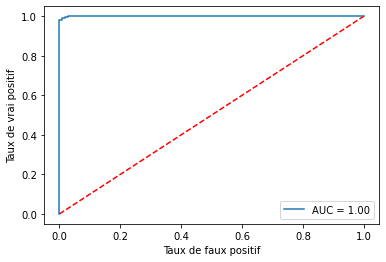

Voici les lignes de prédiction qui diffèrent de la colonne original


,prédiction,probabilité,original
0,False,0.416670,True
591,False,0.414476,True
669,False,0.423595,True
728,False,0.158161,True
1025,True,0.810693,False
1073,True,0.692346,False
1083,True,0.773917,False
1103,True,0.811321,False
1122,True,0.996991,False
1160,True,0.740864,False


'taux de réussite: 99.06666666666666'

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

def model_test(X_test, y_test, model, **kwargs):
    
    # Prédiction des valeurs de la variable cible sur les données de test
    y_pred = model.predict(X_test)

    # Calculer la probabilité de chaque prédiction
    y_prob = model.predict_proba(X_test)[:, 1]

    if kwargs.get('roc_auc', None) == True:
        
        # Calculer la courbe ROC et l'aire sous la courbe ROC (AUC)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        return fpr, tpr, auc
    
    else:
        if kwargs.get('y_pred', None) == True:
            return y_pred, y_prob

def reg_log(df, **kwargs):
    
    X = df[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
    
    if 'is_genuine' in df.columns:
        y = df['is_genuine']
    else:
        y = pd.DataFrame({'is_genuine':[]})
    
    if kwargs.get('model', None) == None:
        # Echantillonner les données en un ensemble d'entraînement et un ensemble de test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Instanciation du modèle de régression logistique
        model_log = LogisticRegression()
        
        # Entraînement du modèle de régression logistique sur les données d'entraînement
        model_log.fit(X_train, y_train)
        
        (fpr,tpr,auc) = model_test(X_test, y_test, model_log, roc_auc=True)
        
        # Calcul de la précision du modèle
        accuracy = model_log.score(X_test, y_test)
        print("accuracy : {:.2f}".format(accuracy))
        
        # Afficher la courbe ROC
        plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('Taux de faux positif')
        plt.ylabel('Taux de vrai positif')
        plt.legend()
        plt.show()

        return model_log
        
    else:
        # Renvoie la prediction y_pred et la probabilité de la prédiction
        res = model_test(X, y, kwargs.get('model'), y_pred=True)
        return pd.DataFrame({'prédiction':res[0],'probabilité':res[1]})

model_log = reg_log(billets)
df_prediction = reg_log(billets, model=model_log)

df_prediction['original'] = billets['is_genuine']
comparaison = df_prediction[df_prediction['prédiction'] != df_prediction['original']]

print("Voici les lignes de prédiction qui diffèrent de la colonne original")
display(comparaison)
display('taux de réussite: '+str(100-(len(comparaison)/len(billets['is_genuine']))*100))

In [12]:
importer("./data_p10/billets_test.csv", sep=",")

billets_test = billets_test.dropna()
df_prediction = reg_log(billets_test, model=model_log)

display(pd.concat([billets_test,df_prediction], axis=1))

./data_p10/billets_test.csv: Importé dans 'billets_test'


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prédiction,probabilité
0,172.09,103.95,103.73,4.39,3.09,113.19,B_1,True,0.989675
1,171.52,104.17,104.03,5.27,3.16,111.82,B_2,False,0.009709
2,171.78,103.80,103.75,3.81,3.24,113.39,B_3,True,0.999180
3,172.02,104.08,103.99,5.57,3.30,111.10,B_4,False,0.000160
4,171.79,104.34,104.37,5.00,3.07,111.87,B_5,False,0.014014
